In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/PFCII/DATASET .
!cp -r /content/drive/MyDrive/PFCII/DATASET ./DATASET2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import numpy as np
import numpy as np
import cv2
import gc
import tensorflow as tf
from tensorflow.keras import backend as K
import glob
import matplotlib.pyplot as plt
import os
import json

path_openpose = '/content/DATASET'
path_MSM = '/content/DATASET2'

ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

In [ ]:
!export TF_FORCE_GPU_ALLOW_GROWTH=True
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
  tf.config.set_visible_devices(gpus[1:], 'GPU')

In [ ]:
def load_videos(video_IDs: list, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
  videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)

  frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

  for i, video_ID in enumerate(video_IDs):
    cap = cv2.VideoCapture(video_ID)
    frames = []
    index = 0
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      if index in frames_idx:
        frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
        if normalize:
          frame /= 255.0
        frames.append(frame)
      index += 1
    cap.release()

    videos[i,] = np.array(frames)

  return videos


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, paths: list = [''], video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
    self.video_IDs = video_IDs
    self.video_labels = video_labels
    self.batch_size = batch_size
    self.paths = paths
    self.video_width = video_width
    self.video_height = video_height
    self.video_frames = video_frames
    self.video_channels = video_channels
    self.dtype = dtype
    self.normalize = normalize
    self.shuffle = shuffle

  def __len__(self):
    return len(self.video_IDs) // self.batch_size

  def __getitem__(self, idx):
    batch_IDs = self.video_IDs[idx * self.batch_size:(idx + 1) * self.batch_size]

    input_videos = []

    for index, path in enumerate(self.paths):
      batch_IDs_full_path = [path+ID for ID in batch_IDs]

      videos = load_videos(batch_IDs_full_path, self.video_frames, self.video_width, self.video_height, self.video_channels, self.dtype, self.normalize)

      input_videos.append(videos)

      labels = np.array([self.video_labels[ID] for ID in batch_IDs])

    return input_videos, labels



In [ ]:
def get_final_path(path):

    index = path.rfind('/train/')
    if index == -1:
        index = path.rfind('/val/')
    return path[index:]

In [ ]:
train_video_paths = [get_final_path(path) for path in glob.glob(path_openpose + '/train/*/*')]
test_video_paths = [get_final_path(path)for path in glob.glob(path_MSM + '/val/*/*')]

train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_paths}
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_paths}

train_generator = DataGenerator(train_video_paths, train_video_labels, batch_size=2, paths=[path_openpose, path_MSM])
test_generator = DataGenerator(test_video_paths, test_video_labels, batch_size=2, paths=[path_openpose, path_MSM])


In [ ]:
inputs_openpose = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
inputs_MSM = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

convolutional_layer1 = tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='relu')
convolutional_layer2 = tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='relu')

inputs_openpose_soft = tf.keras.layers.TimeDistributed(convolutional_layer1)(inputs_openpose)
inputs_MSM_soft = tf.keras.layers.TimeDistributed(convolutional_layer2)(inputs_MSM)

inputs_openpose_norm = tf.keras.layers.BatchNormalization(scale=False, center=False)(inputs_openpose_soft)
inputs_MSM_norm = tf.keras.layers.BatchNormalization(scale=False, center=False)(inputs_MSM_soft)

sigmoid_MSM = tf.keras.activations.sigmoid(inputs_MSM_norm)

inputs_weighted = tf.keras.layers.Multiply()([inputs_openpose_norm, sigmoid_MSM])

x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs_weighted)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model([inputs_MSM, inputs_openpose], outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 51, 100, 100, 3)]    0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 51, 100, 100, 3)]    0         []                            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 51, 98, 98, 9)        252       ['input_2[0][0]']             
 stributed)                                                                                       
                                                                                                  
 time_distributed (TimeDist  (None, 51, 98, 98, 9)        252       ['input_1[0][0]']         

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=test_generator, verbose=2)


Epoch 1/20
6/6 - 74s - loss: 0.6976 - accuracy: 0.1667 - val_loss: 0.6912 - val_accuracy: 0.7500 - 74s/epoch - 12s/step
Epoch 2/20
6/6 - 65s - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 1.0000 - 65s/epoch - 11s/step
Epoch 3/20
6/6 - 66s - loss: 0.6889 - accuracy: 0.7500 - val_loss: 0.6851 - val_accuracy: 0.7500 - 66s/epoch - 11s/step
Epoch 4/20
6/6 - 61s - loss: 0.6908 - accuracy: 0.6667 - val_loss: 0.6803 - val_accuracy: 0.5000 - 61s/epoch - 10s/step
Epoch 5/20
6/6 - 65s - loss: 0.6770 - accuracy: 0.9167 - val_loss: 0.6819 - val_accuracy: 0.7500 - 65s/epoch - 11s/step
Epoch 6/20
6/6 - 60s - loss: 0.6681 - accuracy: 0.7500 - val_loss: 0.6859 - val_accuracy: 0.7500 - 60s/epoch - 10s/step
Epoch 7/20
6/6 - 61s - loss: 0.6397 - accuracy: 0.9167 - val_loss: 0.6835 - val_accuracy: 0.7500 - 61s/epoch - 10s/step
Epoch 8/20
6/6 - 60s - loss: 0.5964 - accuracy: 1.0000 - val_loss: 0.6793 - val_accuracy: 0.7500 - 60s/epoch - 10s/step
Epoch 9/20
6/6 - 66s - loss: 0.5828 - ac

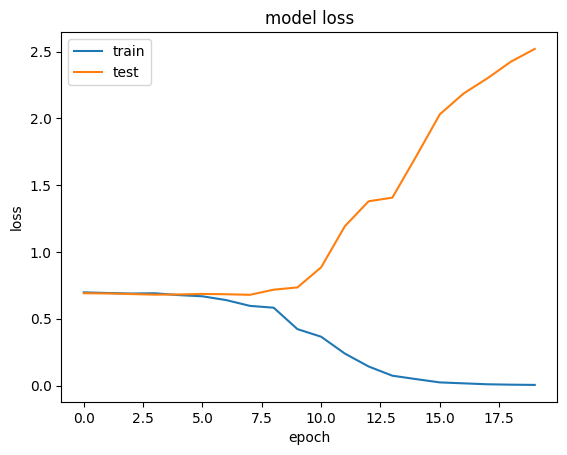

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()